# Data Exploration - Team Gambinos

## Imports

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from nltk import word_tokenize, regexp_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

import scipy

In [2]:
complaints = pd.read_csv('../data/complaints.csv')

## Exploration and Cleaning

We decided as a team to adopt the following naming convention for consistency:

In [3]:
complaints.columns = [x.replace('Consumer ', '').lower().replace(' ', '_') for x in complaints.columns]
complaints['complaint_length'] = complaints['complaint_narrative'].apply(len)


In [4]:
complaints['issue'].value_counts()

Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: issue, dtype: int64

In [5]:
complaints_dict = {'Attempts to collect debt not owed': 0, 
                 'Communication tactics': 1, 
                 'Fraud or scam': 2, 
                 'Incorrect information on your report': 3,
                 'Struggling to pay mortgage': 4}

In [6]:
# to replace the text in issue with target variables
complaints = complaints.replace({'issue': complaints_dict})

In [7]:
complaints['complaint_narrative']

0         My name is XXXX XXXX this complaint is not mad...
1         I searched on XXXX for XXXXXXXX XXXX  and was ...
2         I have a particular account that is stating th...
3         I have not supplied proof under the doctrine o...
4         Hello i'm writing regarding account on my cred...
                                ...                        
353427           Collections account I have no knowledge of
353428    Dear CFPB Team, The reason for my complaint is...
353429    FRCA violations : Failing to Follow Debt Dispu...
353430    My Father, a XXXX XXXX  acquired an HECM rever...
353431    I have tried to contact cash app about a fraud...
Name: complaint_narrative, Length: 353432, dtype: object

In [8]:
seed = 123
for complaint in complaints.loc[complaints['issue'] == 4, 'complaint_narrative'].sample(3, random_state=seed):
    print(complaint)
    print('-----------------------------')

THIS IS A SECOND COMPLAINT PLEASE DO NOT MARK AS DUPLICATE COMPLAINT BECAUSE THIS COMPLAINT IS IN REGARDS MY MORTGAGE ASSISTANCE APPLICATION DENIED ON XX/XX/2019 This year I was facing foreclosure because I can not afford the payments for a loan that I have with Chase because with the years the payment has steadily increased from {$130.00} to {$260.00} per month, also my health and financial situation are not the same as when I applied for the loan and the living expenses increased -Property tax, utility cost, Gas prices, Health Insurance- . I applied 2 times for a mortgage assistance and both applications have been denied, Chase just offered me a short sale or a deed-in-lieu of foreclosure but both options will make me a XXXX homeless person. I am just asking to reduce my monthly payment in order to keep a place to leave, have food in my table and have all the medicines and medical treatments that I need to keep me alive. During the last 10 years or so I have been inundated with medic

In [9]:
# remove double x-s or more
complaints['complaint_narrative'] = complaints['complaint_narrative'].str.replace(r'[xX][xX]+','', regex=True)

# remove double __ or more
complaints['complaint_narrative'] = complaints['complaint_narrative'].str.replace(r'__+','', regex=True)

# stripping all numeric values from complaints
complaints['complaint_narrative'] = complaints['complaint_narrative'].str.replace('\d+', '', regex=True)

# removing digit removes "4927" words

In [10]:
#complaints.groupby('issue')['complaint_narrative'].apply(lambda x: x.str.extractall(r'(\w+X+\w+)').groupby(0).size().reset_index(name='count'))

In [11]:
complaints.loc[complaints['complaint_narrative'].str.find('TOXIC') != -1, 'complaint_narrative'].iloc[3]

'  and      , CA  NATIONSTAR/.   #  We need immediate assistance with our   property loan.     is the investor of the property and   is the servicer for the loan. \n\nOur property has a domestic water well and the water is unsafe to drink. The significant and very serious water contaminations in the aquifers that serve our water well include : Lead Hexavalent Chromium ( documented in the movie entitled   ) and Arsenic. These chemicals are listed on the CA Proposition  List of Contaminants that Cause Cancer or Reproductive Harm. Serial testing of the water well by a CA Certified Laboratory defined the contamination to be steady-state as we were informed by the US EPA. There is no filtration system that can reduce these high levels down to potable safe drinking water levels. Our home is now defined* as : HAZARDOUS TOXIC CONTAMINATED UNINHABITABLE POLLUTED NON-POTABLE WATER BLIGHTED AND A NUISANCE ( *as defined by the CA List of Contaminants Proposition  State of CA, EPA Office of Environ

## First Tokenization

Attempted both with and without lemmatizing.

In [12]:
X = complaints[['complaint_narrative', 'complaint_length']]
y = complaints['issue']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

In [13]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t).lower()
                for t in regexp_tokenize(doc, r'(?u)\b\w\w+\b')
                if t.lower() not in stop_words]

In [14]:
# note: the default stop words remove 311 words; have to specify it, otherwise it's off
#vect = CountVectorizer(lowercase=True, stop_words='english', ) 

#r”(?u)\b\w\w+\b”
stop_words = set(stopwords.words('english'))
vect = CountVectorizer(tokenizer=LemmaTokenizer(), min_df=2, max_df=0.8)  

X_train_vec = vect.fit_transform(X_train['complaint_narrative'])
X_test_vec = vect.transform(X_test['complaint_narrative'])

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
vect.vocabulary_

{'filed': 11510,
 'identity': 14264,
 'theft': 28985,
 'report': 24375,
 'learned': 16801,
 'someone': 27042,
 'using': 31185,
 'incarceration': 14745,
 'submitted': 27953,
 'documentation': 9144,
 'transunion': 29817,
 'disregarded': 8930,
 'even': 10547,
 'block': 3590,
 'account': 301,
 'day': 7411,
 'upon': 31066,
 'receiving': 23395,
 'information': 15149,
 'also': 1290,
 'received': 23385,
 'letter': 16950,
 'irs': 16009,
 'stating': 27538,
 'tax': 28643,
 'return': 24976,
 'name': 18971,
 'u': 30169,
 'dept': 8085,
 'educatio': 9662,
 'acct': 362,
 'closed': 5317,
 'send': 26079,
 'written': 32556,
 'notification': 19579,
 'reported': 24385,
 'consumer': 6321,
 'reporting': 24399,
 'agency': 944,
 'never': 19259,
 'ever': 10556,
 'late': 16679,
 'although': 1311,
 'updated': 31029,
 'chargeoff': 4897,
 'providing': 22660,
 'severe': 26259,
 'scandalous': 25731,
 'action': 507,
 'destroying': 8248,
 'perfect': 21171,
 'payment': 21001,
 'history': 13769,
 'credit': 6981,
 'battle

In [16]:
len(vect.vocabulary_)

32784

## Naive Bayes Classification

In [17]:
word_counts = pd.DataFrame({
    'words': vect.get_feature_names_out(),
    'frequency': np.array(X_train_vec.sum(axis = 0)).flatten()
})

word_counts.head(20)

,words,frequency
0,_acct,2
1,_addresses,6
2,_chapter,4
3,_collections,2
4,_dept,2
5,_employment,8
6,_hard,3
7,_identity,3
8,_included,2
9,_local,3


In [18]:
word_counts[word_counts['frequency'] < 3]

,words,frequency
0,_acct,2
3,_collections,2
4,_dept,2
8,_included,2
10,_me,2
...,...,...
32761,zestfinance,2
32762,zestimate,2
32764,zi,2
32778,zoning,2


In [19]:
word_counts.sort_values('frequency', ascending=False).head(25)

,words,frequency
6981,credit,553340
301,account,509923
24375,report,359288
15149,information,290532
24399,reporting,213314
7492,debt,182786
21001,payment,172136
6321,consumer,168238
5773,company,133872
2836,balance,120282


In [20]:
from sklearn.naive_bayes import MultinomialNB

In [21]:
nb = MultinomialNB().fit(X_train_vec, y_train)

y_pred = nb.predict(X_test_vec)

In [22]:
accuracy_score(y_test, y_pred)

0.8202313316281491

In [23]:
confusion_matrix(y_test, y_pred)

array([[11629,  2133,   472,  3770,   287],
       [  556,  4533,    49,    96,    77],
       [   60,    62,  2825,   109,    31],
       [ 4822,   880,   771, 49259,  1594],
       [   29,    36,    17,    33,  4228]])

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66     18291
           1       0.59      0.85      0.70      5311
           2       0.68      0.92      0.78      3087
           3       0.92      0.86      0.89     57326
           4       0.68      0.97      0.80      4343

    accuracy                           0.82     88358
   macro avg       0.71      0.85      0.77     88358
weighted avg       0.83      0.82      0.82     88358



## LogReg

In [25]:
logreg = LogisticRegression(max_iter = 10000).fit(X_train_vec, y_train)

y_pred = logreg.predict(X_test_vec)

print(accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

In [ ]:
vect = TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))

X_train_vec = vect.fit_transform(X_train['complaint_narrative'])
X_test_vec= vect.transform(X_test['complaint_narrative'])

In [ ]:
logreg = LogisticRegression(max_iter = 10000).fit(X_train_vec, y_train)
y_pred = logreg.predict(X_test_vec)

print(accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.8958102265782385
[[13593   546   100  3969    83]
 [  902  4122    13   250    24]
 [  104    27  2685   261    10]
 [ 2309    53    45 54770   149]
 [   44    29    11   277  3982]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     18291
           1       0.86      0.78      0.82      5311
           2       0.94      0.87      0.90      3087
           3       0.92      0.96      0.94     57326
           4       0.94      0.92      0.93      4343

    accuracy                           0.90     88358
   macro avg       0.89      0.85      0.87     88358
weighted avg       0.89      0.90      0.89     88358



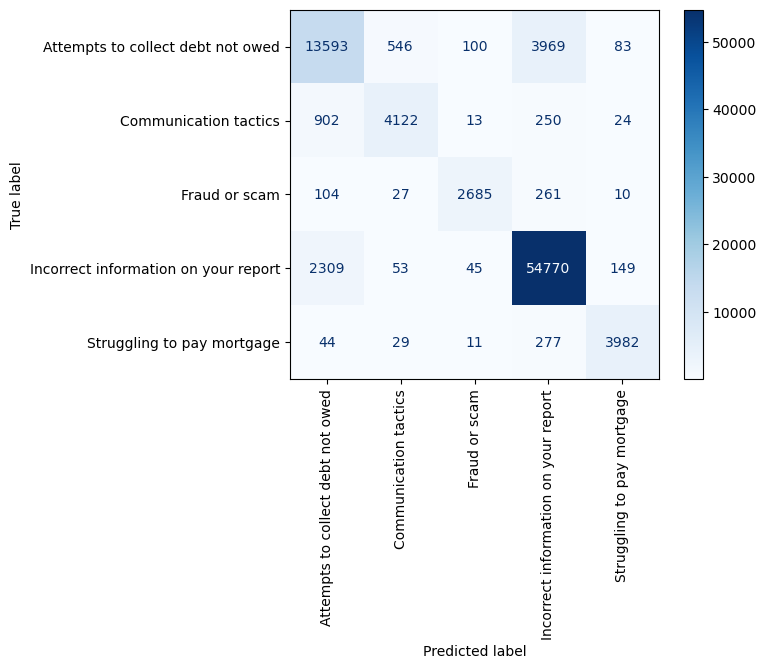

In [ ]:
ConfusionMatrixDisplay.from_estimator(
        logreg,
        X_test_vec,
        y_test,
        display_labels=complaints_dict,
        cmap=plt.cm.Blues,
        #normalize='true',
        xticks_rotation=90
    );

In [ ]:
import plotly.express as px

In [ ]:
fig = px.imshow(confusion_matrix(y_test, y_pred),
                width=1000,
                height=800,
                text_auto=True,
                labels=dict(x="Predicted Label",
                            y="True Label"),
                            x=tuple(complaints_dict.keys()),
                            y=tuple(complaints_dict.keys()),
                            color_continuous_scale='Teal'
                            )

fig.update(layout_coloraxis_showscale=False)
#fig.update_layout(zaxis = dict(tickformat = "digits"))
fig.show()

#fig.write_html('confusion_matrix.html')

## XGBOOST version

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# bst = XGBClassifier(n_estimators=1000,
#                     max_depth=6,
#                     learning_rate=0.001,
#                     subsample=0.8,
#                     # reg_lambda=2,
#                     # reg_alpha=1,
#                     #objective='binary:logistic'
#                     )

bst = XGBClassifier()# n_estimators=300, max_depth=5, learning_rate=0.03, subsample=0.8)

bst.fit(X_train_vec, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_pred = bst.predict(X_test_vec)

print(accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.8827836755019353
[[13111   649   114  4315   102]
 [  998  3975    29   284    25]
 [   98    32  2663   285     9]
 [ 2759    89    67 54263   148]
 [   57    37    25   235  3989]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.74     18291
           1       0.83      0.75      0.79      5311
           2       0.92      0.86      0.89      3087
           3       0.91      0.95      0.93     57326
           4       0.93      0.92      0.93      4343

    accuracy                           0.88     88358
   macro avg       0.87      0.84      0.86     88358
weighted avg       0.88      0.88      0.88     88358



## LogReg + additional features

Here, I'll add other features (for right now only the complaint length).

In [ ]:
vect = TfidfVectorizer(min_df=2, max_df=0.8)

X_train_enhanced = vect.fit_transform(X_train['complaint_narrative'])
X_test_enhanced = vect.transform(X_test['complaint_narrative'])

Here is the addition; converting the complaint length from a dense matrix to a sparse one and adding it.

In [ ]:
train_complaint_length = scipy.sparse.csr_matrix(X_train['complaint_length'].values.reshape(-1,1))
test_complaint_length = scipy.sparse.csr_matrix(X_test['complaint_length'].values.reshape(-1,1))

X_train_enhanced = scipy.sparse.hstack((X_train_enhanced, train_complaint_length))
X_test_enhanced = scipy.sparse.hstack((X_test_enhanced, test_complaint_length))

In [ ]:
# note this takes about 10 min to run!!
pipe_logreg = Pipeline(
    steps = [
        ('scaler', StandardScaler(with_mean=False)),
        ('logreg', LogisticRegression(max_iter = 10000))
    ]
)

pipe_logreg.fit(X_train_enhanced, y_train)

y_pred = pipe_logreg.predict(X_test_enhanced)

print(accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

## Exploring the incorrect classifications

In [ ]:
complaints_dict

{'Attempts to collect debt not owed': 1,
 'Communication tactics': 2,
 'Fraud or scam': 3,
 'Incorrect information on your report': 4,
 'Struggling to pay mortgage': 5}

In order to see what happens where the complaints get wrongly classified, we first need to extract the indexes of where y_test and y_pred don't match.

That is done by first grabbing the index from y_test corresponding to the value of interest (e.g. 1) and seeing where that was incorrectly predicted as something else with y_pred (e.g. 2). Intersect those two to get the indices of where this wrong classification happened

In [ ]:
test_index = np.where(y_test == 0)[0]
pred_index = np.where(y_pred == 3)[0]

test_pred_index = np.intersect1d(test_index, pred_index)

print(len(test_pred_index))
print(test_pred_index)

5222
[   12    25    42 ... 88212 88216 88301]


In [ ]:
y_test.index[test_pred_index[0]]

72776

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
X_test.iloc[test_pred_index[2]]

complaint_narrative    Upon checking my credit report I noticed some unauthorized accounts.
complaint_length                                                                         68
Name: 334837, dtype: object

In [ ]:
print(X_test_vec[test_pred_index[0]])

  (0, 36167)	0.08929908085981164
  (0, 36152)	0.10303054411859254
  (0, 36106)	0.046288960514785704
  (0, 35929)	0.03688838389510342
  (0, 35855)	0.056849521312081416
  (0, 35731)	0.02182982631220426
  (0, 35644)	0.038361046964481026
  (0, 35306)	0.11195961931780653
  (0, 35254)	0.09235477329213299
  (0, 34761)	0.05368378740134921
  (0, 34268)	0.04183851742807523
  (0, 33727)	0.058615390905742686
  (0, 33354)	0.10472721098624081
  (0, 32629)	0.08348528869757116
  (0, 32492)	0.036999559953848044
  (0, 32274)	0.03952507390076191
  (0, 32257)	0.06538925084796646
  (0, 32256)	0.0689776315881583
  (0, 32216)	0.02390224959608656
  (0, 32133)	0.17637843487895838
  (0, 32102)	0.07559885326595092
  (0, 32024)	0.07838412954176038
  (0, 32007)	0.15351933669758772
  (0, 31827)	0.09249402667049508
  (0, 31821)	0.12213779758187286
  :	:
  (0, 4148)	0.12355553424621753
  (0, 3765)	0.1338647639320429
  (0, 3746)	0.16511008543251104
  (0, 3421)	0.0749391127957066
  (0, 2993)	0.08427121220471996
  (0, 2

In [ ]:
vect.get_feature_names_out()[35254]

'was'

NOTE: this was one of the last projects before starting on the Capstone. As a result, there are additional options that can be looked into!